# Определение автора произведения по предложению из текста
Один мой друг рассказывал, что в студенческие годы удивлял одногруппников тем, что мог почти безошибочно определить писателя по отрывку из его произведения. Попробуем что-то похожее сделать средствами машинного обучения. В качестве данных взят training set из уже завершённого соревнования Spooky Author Identification (https://www.kaggle.com/c/spooky-author-identification/data).

Ценность задачи может состоять, например, в том, что похожими методами можно определить автора текста, писавшего под псевдонимом (если известен примерный круг "подозреваемых").

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

## Первичный анализ
Загрузим данные и посмотрим на них.

In [2]:
data = pd.read_csv('../../data/spooky_authors.csv')
data.shape

(19579, 3)

In [3]:
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
np.unique(data['author'])

array(['EAP', 'HPL', 'MWS'], dtype=object)

Набор данных содержит три поля:
* id - идентификатор строки (не представляет интереса)
* text - предложение из текста произведения одного из трёх авторов
* author - автор, а именно:
    * EAP - Edgar Allan Poe
    * HPL - H.P. Lovecraft
    * MWS - Mary Wollstonecraft Shelley
    
Посмотрим, сбалансированы ли классы.

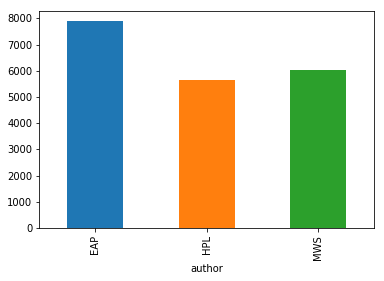

In [5]:
data.groupby('author')['id'].count().plot(kind='bar')

Количество данных по разным авторам несколько отличается, но не слишком сильно.

Вытащим из текста слова и посмотрим, отличаются ли у авторов количество слов в предложении, средняя длина слова, количество пунктуации и т.д.

In [6]:
words = data['text'].apply(lambda t: [w.lower() for w in re.findall(r'\b[^\W\d_]+\b', t)])

Сначала посмотрим на количество слов в предложении.

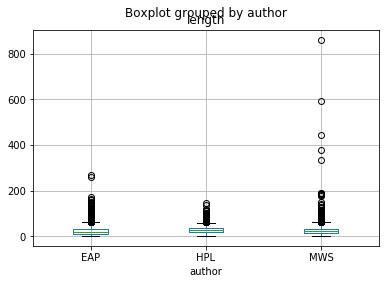

In [7]:
data['length'] = words.apply(lambda ws: len(ws))
data.boxplot(column='length',by='author')

Пока видно только различие по аномально длинным предложениям. Выбросы достигают 800+ слов, но только единичные предложения выходят за 200 слов, а основная масса лежит где-то в пределах пятидесяти.

In [8]:
data['length'].describe()

count    19579.000000
mean        26.811328
std         19.103357
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: length, dtype: float64

Построим такой же график, но исключив крайние выбросы.

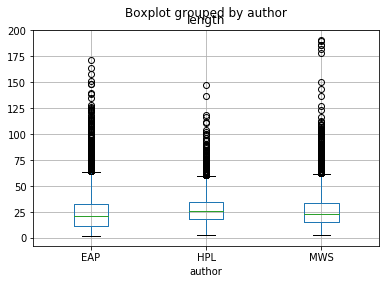

In [9]:
data[data['length'] < 200].boxplot(column='length',by='author')

Теперь отличия более заметны (например, короткие предложения чаще встречаются у Эдгара По, а у Лавкрафта самое узкое расределение, т.е. очень длинные и очень короткие предложения скорее всего не его).

Посмотрим теперь на количество уникальных слов в предложении.

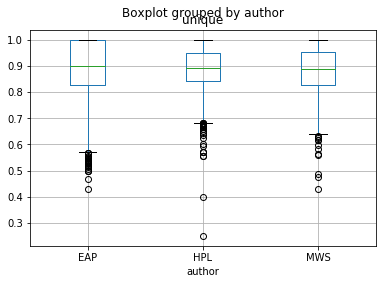

In [10]:
data['unique'] = words.apply(lambda ws: len(set(ws)) / len(ws))
data.boxplot(column='unique',by='author')

И вновь у Эдгара По больше крайних значений, а у Лавкрафта самое узкое распределение.

Посмотрим на среднюю длину слова в предложении.

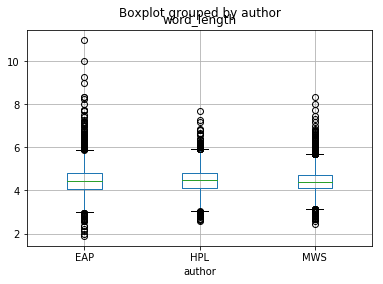

In [11]:
data['word_length'] = words.apply(lambda ws: np.mean([len(w) for w in ws]))
data.boxplot(column='word_length',by='author')

И вновь можно сказать, что самые низкие значения характерны для По, а у Лавкрафта практически нет ни очень высоких, ни очень низких значений.

Наконец, посмотрим, какая часть символов является пунктуацией.

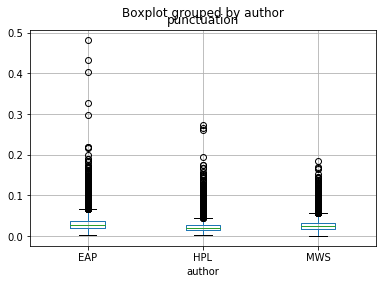

In [12]:
data['punctuation'] = data['text'].apply(lambda t: sum(map(lambda letter: letter in string.punctuation, t)) / len(t))
data.boxplot(column='punctuation',by='author')

Из-за выбросов график трудно интерпретировать, посмотрим ближе значения, не превышающие 0.2

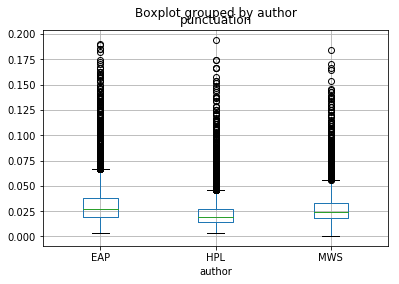

In [13]:
data[data['punctuation'] < 0.2].boxplot(column='punctuation',by='author')

Теперь отличия видны лучше. Наибольшее количество пунктуации характерно для По, наименьшее - для Лавкрафта.

Матрица корреляций этих признаков скорее всего будет не очень информативной, но раз она несколько раз упоминается в плане и критериях оценки, то построим её.

In [14]:
data[['length', 'unique', 'word_length', 'punctuation']].corr()

,length,unique,word_length,punctuation
length,1.000000,-0.627469,0.014098,-0.230435
unique,-0.627469,1.000000,0.102258,0.176632
word_length,0.014098,0.102258,1.000000,-0.215379
punctuation,-0.230435,0.176632,-0.215379,1.000000


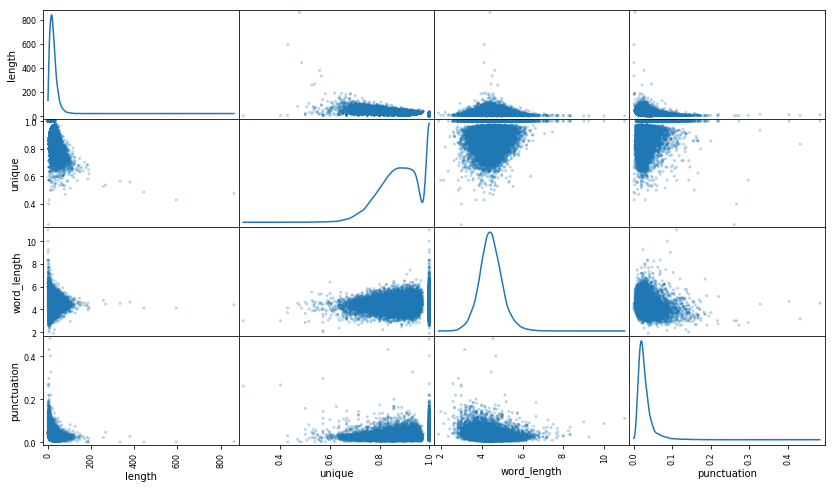

In [15]:
pd.plotting.scatter_matrix(data[['length', 'unique', 'word_length', 'punctuation']], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Как и ожидалось, заметная корреляция только одна: отрицательная корреляция между длиной предложения и количеством уникальных слов в нём. Это логично: чем длиннее предложение, тем вероятнее в нём будут повторяться слова. Если бы значение корреляции было близко к -1, один из признаков стоило бы откинуть, но поскольку только -0.63, то пусть остаются оба.

## Обучение модели

Перейдём собственно к обучению. Первым делом надо ответить на следующие вопросы:
* Что выбрать в качестве метрики качества.
* Использовать ли TF-IDF или достаточно просто CountVectorizer.
* Какой алгоритм использовать. В курсе для подобных задач мы всегда использовали линейные методы, но для задач классификации текстов классическим вариантом также является наивный байесовский классификатор.

В качестве метрики качества можно было бы выбрать accuracy score или log-loss. Accuracy score для данной задачи была бы вполне применима (классы более-менее сбалансированы, и у нас нет предпочтений, в какую сторону менее болезненно было бы ошибаться), тем более, что у accuracy score очень хорошая интерпретируемость. Но log-loss является более тонкой метрикой, позволяющей оптимизировать не только правильность ответа, но и степень уверенности в нём.

Т.о. в качестве метрики качества будет взят log-loss (но accuracy score будем тоже выводить, просто для информации).

Что касается использования TF-IDF и выбора алгоритма ответ прост: мы попробуем разные варианты и посмотрим, что работает лучше. Линейные методы должны работать неплохо для разреженных данных большой размерности (которые у нас получатся после векторизации). Байсовские методы тоже должны неплохо справляться с такими задачами.

Кроме того, мы сначала попробуем обучать только на самих текстах, а потом посмотрим, дадут ли прирост проанализированные фичи вроде длины предложения и количества пунктуации. Скорее всего, эти признаки смогут немного улучшить модель, т.к. такие вещи как длина предложения, длина слов, знаки препинания отражают стиль писателя наравне с используемыми словами (и как мы видели выше у разных писателей на самом деле эти параметры немного отличаются).

Кросс-валидацию будем проводить сразу вместе с поиском оптимальных параметров через GridSearchCV. По умолчанию GridSearchCV использует StratifiedKFold (то есть все во фолды попадёт примерно равное количество представителей каждого класса) и количество фолдов, равное 3. Эти умолчания представляются разумными, так что оставим их.

Для надёжности также выделим отдельно validation set чтобы проверять на нём промежуточные результаты и test set, на котором проверим итоговую модель в самом конце.

Итак, разобьём данные на train, validation и test.

In [16]:
X = data.drop(['id', 'author'], axis=1)
author_encoder = LabelEncoder()
y = author_encoder.fit_transform(data['author'])

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

text_train = X_train['text']
text_val = X_val['text']
text_train_val = X_train_val['text']
text_test = X_test['text']

print(X.shape, y.shape)
print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(19579, 5) (19579,)
(15663, 5) (3916, 5) (15663,) (3916,)
(12530, 5) (3133, 5) (12530,) (3133,)


Напишем небольшую функцию для вывода результатов обучения:

In [17]:
def print_results(clf, x_val, y_val):
    y_pred_val_proba = clf.predict_proba(x_val)
    y_pred_val_labels = clf.predict(x_val)
    print("Validation set log loss: {} (accuracy: {})".format(log_loss(y_val, y_pred_val_proba), accuracy_score(y_val, y_pred_val_labels)))

Подготовим векторайзеры и преобразуем данные.

In [18]:
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(text_train)
count_val = count_vectorizer.transform(text_val)

tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(text_train)
tfidf_val = tfidf_vectorizer.transform(text_val)

## Логистическая регрессия

Начнём с самого простого варианта: CountVectorizer и логистическая регрессия.

In [19]:
logit_count_clf = LogisticRegression().fit(count_train, y_train)
print_results(logit_count_clf, count_val, y_val)

Validation set log loss: 0.46988480320038806 (accuracy: 0.8126396425151612)


Уже неплохо. Попробуем настроить регуляризацию.

In [20]:
logit_count_grid = GridSearchCV(LogisticRegression(random_state=17), {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_count_grid.fit(count_train, y_train)
print(logit_count_grid.best_params_, ', cross validation score:', -logit_count_grid.best_score_)
print_results(logit_count_grid, count_val, y_val)

{'C': 1} , cross validation score: 0.517360860313
Validation set log loss: 0.46988480320038806 (accuracy: 0.8126396425151612)


Значение по умолчанию оказалось оптимальным.

Попробуем TF-IDF.

In [21]:
logit_tfidf_clf = LogisticRegression(random_state=17).fit(tfidf_train, y_train)
print_results(logit_tfidf_clf, tfidf_val, y_val)

Validation set log loss: 0.6104448039923541 (accuracy: 0.8005106926268752)


Результат существенно хуже (видно, что accuracy изменилась несущественно, но уверены в предсказаниях мы намного меньше).

Возможно, дело в регуляризации.

In [22]:
logit_tfidf_grid = GridSearchCV(LogisticRegression(random_state=17), {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_tfidf_grid.fit(tfidf_train, y_train)
print(logit_tfidf_grid.best_params_, ', cross validation score:', -logit_tfidf_grid.best_score_)
print_results(logit_tfidf_grid, tfidf_val, y_val)

{'C': 30} , cross validation score: 0.509468171025
Validation set log loss: 0.4603209366113612 (accuracy: 0.8218959463772741)


После настройки регуляризации результат намного лучше (и чуть лучше, чем без TF-IDF).

Проверим, изменится ли результат, если применить логарифмическое преобразование к TF.

In [23]:
tfidf_log_vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_log_train = tfidf_log_vectorizer.fit_transform(text_train)
tfidf_log_val = tfidf_log_vectorizer.transform(text_val)

In [24]:
logit_tfidf_log_grid = GridSearchCV(LogisticRegression(random_state=17), {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_tfidf_log_grid.fit(tfidf_log_train, y_train)
print(logit_tfidf_log_grid.best_params_, ', cross validation score:', -logit_tfidf_log_grid.best_score_)
print_results(logit_tfidf_log_grid, tfidf_log_val, y_val)

{'C': 30} , cross validation score: 0.508630646692
Validation set log loss: 0.4615441134464635 (accuracy: 0.8206192148100862)


Неа.

Попробуем, не будет ли результат лучше, если использовать биграммы.

In [25]:
tfidf_12_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_12_train = tfidf_12_vectorizer.fit_transform(text_train)
tfidf_12_val = tfidf_12_vectorizer.transform(text_val)

In [26]:
logit_tfidf_12_grid = GridSearchCV(LogisticRegression(random_state=17), {'C': [0.1, 0.3, 1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_tfidf_12_grid.fit(tfidf_12_train, y_train)
print(logit_tfidf_12_grid.best_params_, ', cross validation score:', -logit_tfidf_12_grid.best_score_)
print_results(logit_tfidf_12_grid, tfidf_12_val, y_val)

{'C': 100} , cross validation score: 0.492091715167
Validation set log loss: 0.45264964974042277 (accuracy: 0.8314714331311842)


Немного лучше.
А если триграммы?

In [27]:
tfidf_13_vectorizer = TfidfVectorizer(ngram_range=(1, 3))
tfidf_13_train = tfidf_13_vectorizer.fit_transform(text_train)
tfidf_13_val = tfidf_13_vectorizer.transform(text_val)

In [28]:
logit_tfidf_13_grid = GridSearchCV(LogisticRegression(random_state=17), {'C': [1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_tfidf_13_grid.fit(tfidf_13_train, y_train)
print(logit_tfidf_13_grid.best_params_, ', cross validation score:', -logit_tfidf_13_grid.best_score_)
print_results(logit_tfidf_13_grid, tfidf_13_val, y_val)

{'C': 300} , cross validation score: 0.518406479122
Validation set log loss: 0.4988425935238636 (accuracy: 0.8209383977018831)


Оставим биграммы. И попробуем добавить наши дополнительные фичи.

In [29]:
tfidf_12_ext_train = hstack([tfidf_12_train, X_train[['length', 'unique', 'word_length', 'punctuation']]]).tocsr()
tfidf_12_ext_val = hstack([tfidf_12_val, X_val[['length', 'unique', 'word_length', 'punctuation']]]).tocsr()

logit_tfidf_12_ext_grid = GridSearchCV(LogisticRegression(), {'C': [1, 3, 10, 30, 100, 300]}, scoring='neg_log_loss')
logit_tfidf_12_ext_grid.fit(tfidf_12_ext_train, y_train)
print(logit_tfidf_12_ext_grid.best_params_, -logit_tfidf_12_ext_grid.best_score_)
print_results(logit_tfidf_12_ext_grid, tfidf_12_ext_val, y_val)

{'C': 100} 0.486261757609
Validation set log loss: 0.44892470788092376 (accuracy: 0.8311522502393872)


Прирост не то чтобы очень большой, но есть.

## Кривые валидации и обучения
Построим кривую обучения (log loss в зависимости от размера обучающей выборки).

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_log_loss')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [31]:
tfidf_12_vectorizer_train_val = tfidf_12_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_12_train_val = tfidf_12_vectorizer_train_val.fit_transform(text_train_val)
tfidf_12_ext_train_val = hstack([tfidf_12_train_val, X_train_val[['length', 'unique', 'word_length', 'punctuation']]]).tocsr()

<module 'matplotlib.pyplot' from 'C:\\Programs\\Anaconda3\\envs\\py36\\lib\\site-packages\\matplotlib\\pyplot.py'>

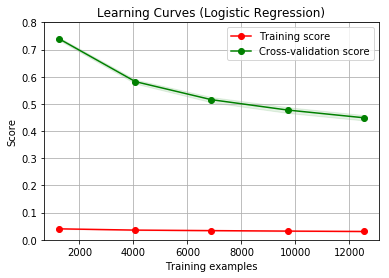

In [32]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=4, test_size=0.2, random_state=0)
plot_learning_curve(LogisticRegression(C=100), title, tfidf_12_ext_train_val, y_train_val, ylim=(0, 0.8), cv=cv, n_jobs=4)

Кривая, соответствующая кросс-валидации, спускается вниз, но находится очень далеко от кривой, соответствующей обучению. Это говорит о том, что у нас большое недообучение и может помочь больше данных.

Построим кривую валидации (для разных параметров C).

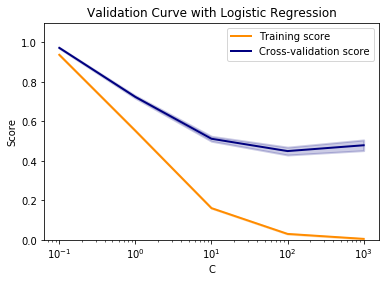

In [35]:
param_range = np.logspace(-1, 3, 5)
train_scores, test_scores = validation_curve(
    LogisticRegression(C=100), tfidf_12_ext_train_val, y_train_val, param_name="C", param_range=param_range,
    cv=4, scoring="neg_log_loss", n_jobs=4)
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logistic Regression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Кривая валидации спускается вниз, но после C=100 снова поднимается наверх и начинается переобучение. Т.о. выбранное через GridSearch значение оптимально.

## Байесовские методы
Попробуем теперь байесовские методы.

Как и в случае логистической регрессии начнём с самого простого варианта: CountVectorizer + MultinomialNB без настройки параметров.

In [36]:
nb_count_clf = MultinomialNB().fit(count_train, y_train)
print_results(logit_count_clf, count_val, y_val)

Validation set log loss: 0.46988480320038806 (accuracy: 0.8126396425151612)


Результат очень похож на результаты логистической регрессии. Попробуем настроить параметры alpha

In [37]:
nb_count_grid = GridSearchCV(MultinomialNB(), {'alpha': [0.01, 0.01, 0.1, 1]}, scoring='neg_log_loss')
nb_count_grid.fit(count_train, y_train)
print(nb_count_grid.best_params_, ', cross validation score:', -nb_count_grid.best_score_)
print_results(nb_count_grid, count_val, y_val)

{'alpha': 1} , cross validation score: 0.521590266113
Validation set log loss: 0.46375967585872935 (accuracy: 0.8356208107245452)


Попробуем TF-IDF

In [38]:
nb_tfidf_grid = GridSearchCV(MultinomialNB(), {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}, scoring='neg_log_loss')
nb_tfidf_grid.fit(tfidf_train, y_train)
print(nb_tfidf_grid.best_params_, ', cross validation score:', -nb_tfidf_grid.best_score_)
print_results(nb_tfidf_grid, tfidf_val, y_val)

{'alpha': 0.03} , cross validation score: 0.475806211632
Validation set log loss: 0.43597663058711655 (accuracy: 0.8305138844557932)


Результат лучше. Попробуем биграммы.

In [39]:
nb_tfidf_12_grid = GridSearchCV(MultinomialNB(), {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}, scoring='neg_log_loss')
nb_tfidf_12_grid.fit(tfidf_12_train, y_train)
print(nb_tfidf_12_grid.best_params_, ', cross validation score:', -nb_tfidf_12_grid.best_score_)
print_results(nb_tfidf_12_grid, tfidf_12_val, y_val)

{'alpha': 0.01} , cross validation score: 0.448145005027
Validation set log loss: 0.4131409804053453 (accuracy: 0.8295563357804022)


И триграммы.

In [40]:
nb_tfidf_13_grid = GridSearchCV(MultinomialNB(), {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}, scoring='neg_log_loss')
nb_tfidf_13_grid.fit(tfidf_13_train, y_train)
print(nb_tfidf_13_grid.best_params_, ', cross validation score:', -nb_tfidf_13_grid.best_score_)
print_results(nb_tfidf_13_grid, tfidf_13_val, y_val)

{'alpha': 0.01} , cross validation score: 0.479854922346
Validation set log loss: 0.43205118823799815 (accuracy: 0.8330673475901692)


Как и в случае логистической регрессии, триграммы работают хуже, оставим биграммы.

Добавим наши фичи.

In [41]:
nb_tfidf_12_ext_grid = GridSearchCV(MultinomialNB(), {'alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]}, scoring='neg_log_loss')
nb_tfidf_12_ext_grid.fit(tfidf_12_ext_train, y_train)
print(nb_tfidf_12_ext_grid.best_params_, -nb_tfidf_12_ext_grid.best_score_)
print_results(nb_tfidf_12_ext_grid, tfidf_12_ext_val, y_val)

{'alpha': 0.01} 0.445586871104
Validation set log loss: 0.4100103559126104 (accuracy: 0.8305138844557932)


Log-loss чуть лучше, почти достиг 0.41.

Таким образом, лучше всего сработала байесовская модель, обученная на TF-IDF с биграммами и с добавлением новых признаков.

## Предсказания на тестовых данных

Построим теперь предсказания на тестовых данных.

Обучим самую удачную модель на train + validation.

In [42]:
tfidf_12_test = tfidf_12_vectorizer.transform(text_test)
tfidf_12_ext_test = hstack([tfidf_12_test, X_test[['length', 'unique', 'word_length', 'punctuation']]]).tocsr()

nb = MultinomialNB(alpha=0.01)
nb.fit(tfidf_12_ext_train_val, y_train_val)
print_results(nb, tfidf_12_ext_test, y_test)

Validation set log loss: 0.3764864361855034 (accuracy: 0.8559754851889684)


Т.о. финальный результат на тестовой выборке: 0.376486. Результат на тествой выборке получился даже лучше, чем на валидации (0.410010, возможно, из-за того, что обучали на выборке большего размера). Тестовая выборка была получена с рандомизацией при помощи train_test_split.

## Выводы

Итак, обучение прошло успешно, переобучения не произошло.

Как упоминалось в начале, данная модель может использоваться для определения авторов книг и статей, желавших остаться анонимными. Также, в более широком смысле, такие методы могут использоваться для любой классификации текста (например, для классификации заданных через сайт вопросов по темам).

В качестве дальнейших улучшений мне видится:
* Объединить предсказания нескольких успешных моделей (например, логистической регрессии, байеса и чего-нибудь ещё).
* Можно попробовать рекуррентные нейронные сети. Сейчас мы учитываем только биграммы, то есть контекст теряется. Триграммы "в лоб" дают не очень хороший результат. Может быть, RNN смогла бы как-то более тонко учесть контекст и повысить качество предсказаний. С другой стороны, выборка небольшая, может и не хватить данных для обучения нейронной сети.
* Можно попробовать как-то корректировать предсказания (clipping). Но это вряд ли даст сильные изменения в реальной задаче, скорее просто может немного улучшить log-loss.